Свёрточные нейронные сети и transfer learning для изображений.

Датасет: Hotdog / Not hotdog.

Метрика: Accuracy

Сделать модель бинарной классификации изображений с использованием примера имплементации.

- Обучить модель с нуля
- Дообучить предобученную модель
- Сравнить качество

In [2]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
!pip install --upgrade keras

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)
Requirement already up-to-date: keras in c:\anaconda\lib\site-packages (2.2.4)


In [3]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
import json
from tqdm import tqdm
seed = 321



#keras
from sklearn.metrics import f1_score, classification_report
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from keras.regularizers import l1_l2
from keras.layers import LeakyReLU, BatchNormalization
from keras.optimizers import SGD


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Set pictures parameters

In [12]:
img_width = 224
img_height = 224
batch_size = 16
path = "data/task_3/"
img_classes = ['hot_dog','not_hot_dog']

In [9]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #Randomly flip inputs horizontally


test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
#Takes the path to a directory & generates batches of augmented data.
train_generator = train_datagen.flow_from_directory(
    path + "train",  # this is the target directory
    target_size=(img_width, img_height),  # all images will be resized to NxN
    batch_size=batch_size,
    class_mode='binary',# since we use binary_crossentropy loss, we need binary labels
    classes = img_classes,
    seed=seed)  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        path + "test",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes = img_classes,
        seed=seed)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


View train/test image before preprocess

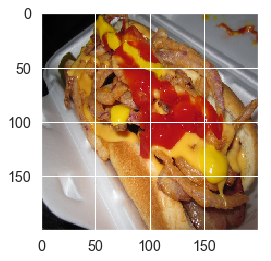

In [28]:
img = load_img(path + "train/hot_dog/2417.jpg",target_size=(img_width, img_height))  # this is a PIL image
#x = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

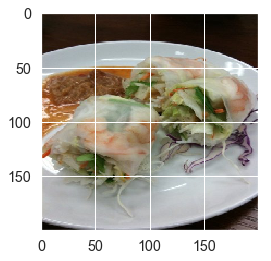

In [33]:
img = load_img(path + "train/not_hot_dog/197.jpg",target_size=(img_width, img_height))  # this is a PIL image
#x = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)


And after preprocess

In [34]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='data/task_3/preview', save_prefix='not_hot_dog', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely